In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt

from loader import All_fundus_files
from networks import weights_init, Discriminator_128_v2, Flatten

dataroot = "data/fundus2/"
batch_size = 64
image_size = 128 #size using data aug.
num_classes = 5

ch_out = 3 
#ch_noise = 100
#ch_g = 64
ch_d = 64

num_epochs = 500
lr = 0.0002
beta1 = 0.5

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device == 'cuda':
    cudnn.benchmark = True

cuda


In [3]:
# Data
transform_train = transforms.Compose([
    #transforms.RandomResizedCrop(image_size),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.ImageFolder(root=dataroot+'sorted', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

testset = torchvision.datasets.ImageFolder(root=dataroot+'val', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

classes = testset.classes
print(trainset.classes)
print(testset.class_to_idx)
print(len(trainset), len(testset))

['catergory00', 'catergory01', 'catergory02', 'catergory03', 'catergory04']
{'catergory00': 0, 'catergory01': 1, 'catergory02': 2, 'catergory03': 3, 'catergory04': 4}
3462 200


In [4]:
# Model
net = Discriminator_128_v2(ch_out, ch_d)
net.backbone[14] = nn.AdaptiveAvgPool2d((1, 1)) 
net.backbone[15] = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=ch_d * 16, out_features=num_classes, bias=True)
)
net = net.to(device)
net.apply(weights_init)
print(net)

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
'''
if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
    print(best_acc,start_epoch)

'''

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))
#optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [100,250], gamma=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


Discriminator_128_v2(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024

In [5]:
from torchsummary import summary
summary(net, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
       BatchNorm2d-4          [-1, 128, 32, 32]             256
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
       BatchNorm2d-7          [-1, 256, 16, 16]             512
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-10            [-1, 512, 8, 8]           1,024
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12           [-1, 1024, 4, 4]       8,388,608
      BatchNorm2d-13           [-1, 1024, 4, 4]           2,048
        LeakyReLU-14           [-1, 102

In [6]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train Loss: %.3f | Acc: %.3f%% (%d/%d)' %(train_loss / (batch_idx+1), 100.*correct/total, correct, total))
    return train_loss /(batch_idx+1), correct/total

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print('Test Loss: %.3f | Acc: %.3f%% (%d/%d)' %(test_loss /(batch_idx+1), 100.*correct/total, correct, total))
    return test_loss /(batch_idx+1), correct/total

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint/exp3'):
            os.mkdir('checkpoint/exp3')
        torch.save(state, './checkpoint/exp3/ckpt.pth')
        best_acc = acc

Train_losses = []
Test_losses = []
Train_acc = []
Test_acc = []
for epoch in range(start_epoch, start_epoch+num_epochs):
    ls, acc = train(epoch)
    Train_losses.append(ls)
    Train_acc.append(acc)
    
    ls, acc = test(epoch)
    Test_losses.append(ls)
    Test_acc.append(acc)
    
    scheduler.step()


Epoch: 0
Train Loss: 0.897 | Acc: 68.284% (2364/3462)
Test Loss: 2.361 | Acc: 21.500% (43/200)

Epoch: 1
Train Loss: 0.794 | Acc: 71.693% (2482/3462)
Test Loss: 1.603 | Acc: 39.500% (79/200)

Epoch: 2
Train Loss: 0.762 | Acc: 72.964% (2526/3462)
Test Loss: 1.580 | Acc: 42.000% (84/200)

Epoch: 3
Train Loss: 0.773 | Acc: 73.744% (2553/3462)
Test Loss: 1.710 | Acc: 29.000% (58/200)

Epoch: 4
Train Loss: 0.749 | Acc: 73.310% (2538/3462)
Test Loss: 1.582 | Acc: 40.000% (80/200)

Epoch: 5
Train Loss: 0.709 | Acc: 74.408% (2576/3462)
Test Loss: 1.478 | Acc: 48.500% (97/200)

Epoch: 6
Train Loss: 0.700 | Acc: 75.072% (2599/3462)
Test Loss: 1.639 | Acc: 49.500% (99/200)

Epoch: 7
Train Loss: 0.694 | Acc: 75.072% (2599/3462)
Test Loss: 1.355 | Acc: 47.500% (95/200)

Epoch: 8
Train Loss: 0.691 | Acc: 75.852% (2626/3462)
Test Loss: 1.872 | Acc: 37.000% (74/200)

Epoch: 9
Train Loss: 0.675 | Acc: 75.563% (2616/3462)
Test Loss: 1.651 | Acc: 46.500% (93/200)

Epoch: 10
Train Loss: 0.655 | Acc: 76.1

Test Loss: 2.862 | Acc: 53.000% (106/200)

Epoch: 85
Train Loss: 0.074 | Acc: 98.354% (3405/3462)
Test Loss: 3.005 | Acc: 55.000% (110/200)

Epoch: 86
Train Loss: 0.070 | Acc: 98.238% (3401/3462)
Test Loss: 3.066 | Acc: 50.500% (101/200)

Epoch: 87
Train Loss: 0.058 | Acc: 98.556% (3412/3462)
Test Loss: 2.875 | Acc: 53.000% (106/200)

Epoch: 88
Train Loss: 0.057 | Acc: 98.845% (3422/3462)
Test Loss: 2.788 | Acc: 49.500% (99/200)

Epoch: 89
Train Loss: 0.057 | Acc: 98.700% (3417/3462)
Test Loss: 2.502 | Acc: 51.000% (102/200)

Epoch: 90
Train Loss: 0.060 | Acc: 98.642% (3415/3462)
Test Loss: 2.703 | Acc: 51.000% (102/200)

Epoch: 91
Train Loss: 0.051 | Acc: 98.931% (3425/3462)
Test Loss: 2.859 | Acc: 49.000% (98/200)

Epoch: 92
Train Loss: 0.058 | Acc: 98.671% (3416/3462)
Test Loss: 2.826 | Acc: 50.500% (101/200)

Epoch: 93
Train Loss: 0.056 | Acc: 98.816% (3421/3462)
Test Loss: 2.640 | Acc: 49.500% (99/200)

Epoch: 94
Train Loss: 0.069 | Acc: 98.960% (3426/3462)
Test Loss: 2.917 | Acc:

Train Loss: 0.030 | Acc: 99.133% (3432/3462)
Test Loss: 2.770 | Acc: 51.500% (103/200)

Epoch: 169
Train Loss: 0.037 | Acc: 98.989% (3427/3462)
Test Loss: 2.931 | Acc: 50.500% (101/200)

Epoch: 170
Train Loss: 0.045 | Acc: 98.700% (3417/3462)
Test Loss: 3.136 | Acc: 50.000% (100/200)

Epoch: 171
Train Loss: 0.035 | Acc: 99.018% (3428/3462)
Test Loss: 3.166 | Acc: 50.000% (100/200)

Epoch: 172
Train Loss: 0.042 | Acc: 98.816% (3421/3462)
Test Loss: 2.980 | Acc: 49.500% (99/200)

Epoch: 173
Train Loss: 0.051 | Acc: 98.354% (3405/3462)
Test Loss: 2.979 | Acc: 51.000% (102/200)

Epoch: 174
Train Loss: 0.048 | Acc: 98.614% (3414/3462)
Test Loss: 2.387 | Acc: 52.500% (105/200)

Epoch: 175
Train Loss: 0.064 | Acc: 98.007% (3393/3462)
Test Loss: 2.851 | Acc: 49.000% (98/200)

Epoch: 176
Train Loss: 0.041 | Acc: 98.758% (3419/3462)
Test Loss: 2.755 | Acc: 50.500% (101/200)

Epoch: 177
Train Loss: 0.034 | Acc: 99.018% (3428/3462)
Test Loss: 3.195 | Acc: 49.500% (99/200)

Epoch: 178
Train Loss: 0

Test Loss: 3.609 | Acc: 47.500% (95/200)

Epoch: 252
Train Loss: 0.028 | Acc: 98.931% (3425/3462)
Test Loss: 3.176 | Acc: 49.500% (99/200)

Epoch: 253
Train Loss: 0.024 | Acc: 99.133% (3432/3462)
Test Loss: 3.151 | Acc: 50.000% (100/200)

Epoch: 254
Train Loss: 0.079 | Acc: 98.845% (3422/3462)
Test Loss: 3.631 | Acc: 49.500% (99/200)

Epoch: 255
Train Loss: 0.064 | Acc: 97.660% (3381/3462)
Test Loss: 3.032 | Acc: 50.500% (101/200)

Epoch: 256
Train Loss: 0.033 | Acc: 98.787% (3420/3462)
Test Loss: 3.603 | Acc: 49.000% (98/200)

Epoch: 257
Train Loss: 0.036 | Acc: 99.018% (3428/3462)
Test Loss: 3.365 | Acc: 50.000% (100/200)

Epoch: 258
Train Loss: 0.037 | Acc: 98.671% (3416/3462)
Test Loss: 3.521 | Acc: 50.000% (100/200)

Epoch: 259
Train Loss: 0.032 | Acc: 98.960% (3426/3462)
Test Loss: 3.498 | Acc: 51.000% (102/200)

Epoch: 260
Train Loss: 0.025 | Acc: 98.960% (3426/3462)
Test Loss: 3.393 | Acc: 48.500% (97/200)

Epoch: 261
Train Loss: 0.021 | Acc: 99.249% (3436/3462)
Test Loss: 3.51

Train Loss: 0.020 | Acc: 99.018% (3428/3462)
Test Loss: 3.218 | Acc: 48.500% (97/200)

Epoch: 336
Train Loss: 0.019 | Acc: 99.018% (3428/3462)
Test Loss: 3.212 | Acc: 50.500% (101/200)

Epoch: 337
Train Loss: 0.015 | Acc: 99.336% (3439/3462)
Test Loss: 3.298 | Acc: 50.500% (101/200)

Epoch: 338
Train Loss: 0.020 | Acc: 98.989% (3427/3462)
Test Loss: 3.019 | Acc: 50.500% (101/200)

Epoch: 339
Train Loss: 0.023 | Acc: 98.816% (3421/3462)
Test Loss: 3.153 | Acc: 49.500% (99/200)

Epoch: 340
Train Loss: 0.019 | Acc: 99.162% (3433/3462)
Test Loss: 3.254 | Acc: 50.000% (100/200)

Epoch: 341
Train Loss: 0.021 | Acc: 98.902% (3424/3462)
Test Loss: 3.160 | Acc: 48.500% (97/200)

Epoch: 342
Train Loss: 0.031 | Acc: 98.671% (3416/3462)
Test Loss: 3.098 | Acc: 52.000% (104/200)

Epoch: 343
Train Loss: 0.038 | Acc: 98.729% (3418/3462)
Test Loss: 2.891 | Acc: 51.500% (103/200)

Epoch: 344
Train Loss: 0.030 | Acc: 98.902% (3424/3462)
Test Loss: 2.845 | Acc: 52.000% (104/200)

Epoch: 345
Train Loss: 0

Train Loss: 0.016 | Acc: 99.076% (3430/3462)
Test Loss: 3.550 | Acc: 48.500% (97/200)

Epoch: 419
Train Loss: 0.015 | Acc: 99.133% (3432/3462)
Test Loss: 3.222 | Acc: 50.000% (100/200)

Epoch: 420
Train Loss: 0.013 | Acc: 99.249% (3436/3462)
Test Loss: 3.475 | Acc: 50.000% (100/200)

Epoch: 421
Train Loss: 0.017 | Acc: 99.220% (3435/3462)
Test Loss: 3.300 | Acc: 49.500% (99/200)

Epoch: 422
Train Loss: 0.017 | Acc: 99.162% (3433/3462)
Test Loss: 3.438 | Acc: 50.000% (100/200)

Epoch: 423
Train Loss: 0.015 | Acc: 99.076% (3430/3462)
Test Loss: 3.433 | Acc: 50.000% (100/200)

Epoch: 424
Train Loss: 0.015 | Acc: 99.076% (3430/3462)
Test Loss: 3.279 | Acc: 50.000% (100/200)

Epoch: 425
Train Loss: 0.015 | Acc: 99.133% (3432/3462)
Test Loss: 3.294 | Acc: 50.500% (101/200)

Epoch: 426
Train Loss: 0.015 | Acc: 98.989% (3427/3462)
Test Loss: 3.517 | Acc: 52.500% (105/200)

Epoch: 427
Train Loss: 0.015 | Acc: 98.989% (3427/3462)
Test Loss: 3.258 | Acc: 50.000% (100/200)

Epoch: 428
Train Loss: 

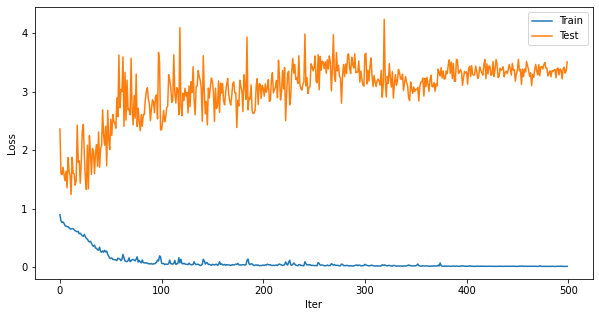

In [11]:
# check loss
plt.figure(figsize=(10,5))
plt.plot(Train_losses,label="Train")
plt.plot(Test_losses,label="Test")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.legend()
plt.show()

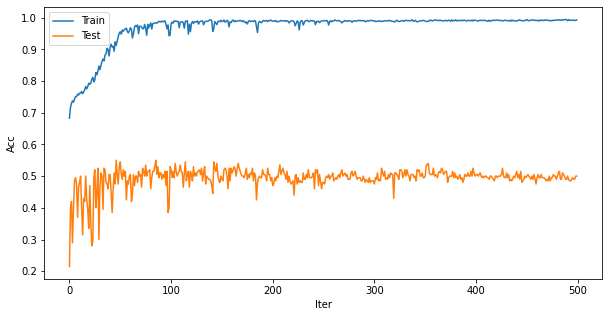

In [12]:
# check acc
plt.figure(figsize=(10,5))
plt.plot(Train_acc,label="Train")
plt.plot(Test_acc,label="Test")
plt.xlabel("Iter")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [9]:
def test_only():
    net.eval()
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels =images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %f %%' % (100 * correct / total))
    return (100 * correct / total)

acc = test_only() 

Accuracy of the network on the 10000 test images: 50.000000 %


In [10]:
def test_each_class():
    net.eval()
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels =images.to(device), labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.2f} %".format(classname,
        accuracy))

test_each_class()

KeyError: tensor(0, device='cuda:0')

In [ ]:
# save
state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
#torch.save(state, './checkpoint/ckpt_fin.pth')

In [ ]:
# load
resume = 'ckpt'
checkpoint = torch.load('./checkpoint/'+resume+'.pth')
#net.load_state_dict(checkpoint['net'])

In [ ]:
acc = test_only() 
test_each_class()